In [1]:
# !pip install casadi
!pip install casadi==3.6.3 # officially supported newest version by acados at the time of writing.
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib

clear_output()

   ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━ 34.6/67.5 MB 3.5 MB/s eta 0:00:10:10

In [2]:
g = 9.81 #重力加速度
M = 1 #台車の質量
m = 0.2 #振子の質量
l = 1 #振子の長さ

nu = 1 #制御変数の次元
nx = 4 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([2.5,10,0.01,0.01])
Q_f = casadi.diag([2.5,10,0.01,0.01])
R = casadi.diag([0.1])

# 予測ホライズン等
T = 1
K = 20
dt = T/K

# 制約条件
x_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
x_ub = [np.inf,np.inf,np.inf,np.inf]
u_lb = [-15]
u_ub = [15]

total = nx*(K+1) + nu*K

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    theta = states[1]
    x_dot = states[2]
    theta_dot = states[3]
    F = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (-m*l*sin*theta_dot**2+m*g*sin*cos+F)/det
    theta_ddot = (-m*l*sin*cos*theta_dot**2+(M+m)*g*sin+F*cos)/(l*det)

    states_dot = casadi.vertcat(x_dot,theta_dot,x_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    cost = (casadi.dot(Q@x,x) + casadi.dot(R@u,u)) / 2
    return cost

def compute_final_cost(x):
    cost = casadi.dot(Q_f@x,x) / 2
    return cost

In [4]:
def make_nlp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k])*dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    # option = {'print_time':False,'ipopt':{'print_level':0}}
    option = {} # printオプションを有効化
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [5]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [6]:
S = make_nlp()

# ↑までは5章と共通

# 5章CasADis実装例を用いる場合の初期時刻における最適化問題の数値解

In [7]:
state_init = np.array([0,np.pi,0,0])
state_init_dm = casadi.DM(state_init) # 初期状態
mpc_x0_init = casadi.DM.zeros(total) # 非線形最適化問題の初期推定

In [8]:
_, x0_casadi = compute_optimal_control(S, state_init_dm, mpc_x0_init)
u_traj_casadi = np.array(x0_casadi[nx*(K+1):]).reshape(-1,nu)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      369
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      157

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:       80
Total number of inequality c

# acadosを用いる場合の初期時刻における最適化問題の数値解

In [9]:
from acados_template import AcadosModel

def export_cart_pole_model() -> AcadosModel:

    model_name = 'cart_pole'
    
    f = make_f()
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)    
    f_expl = f(x=states,u=ctrls)["x_dot"]

    states_dot = casadi.SX.sym("states_dot",nx)
    f_impl = states_dot - f_expl
    model = AcadosModel()

    model.f_impl_expr = f_impl
    model.f_expl_expr = f_expl
    model.x = states
    model.xdot = states_dot
    model.u = ctrls
    model.name = model_name
    return model

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
from acados_template import AcadosOcp, AcadosOcpSolver

print("casadi version:",casadi.__version__)

ocp = AcadosOcp()
model = export_cart_pole_model()
ocp.model = model
ocp.dims.N = K

ocp.cost.cost_type = 'EXTERNAL'
ocp.cost.cost_type_e = 'EXTERNAL'
ocp.model.cost_expr_ext_cost = compute_stage_cost(model.x,model.u)
ocp.model.cost_expr_ext_cost_e = compute_final_cost(model.x)

ocp.constraints.lbu = np.array(u_lb)
ocp.constraints.ubu = np.array(u_ub)
ocp.constraints.idxbu = np.array([0])

ocp.constraints.x0 = state_init

ocp.solver_options.qp_solver = 'PARTIAL_CONDENSING_HPIPM'
ocp.solver_options.qp_solver_cond_N = 5

ocp.solver_options.hpipm_mode = 'SPEED'
# ocp.solver_options.hpipm_mode = 'BALANCE' 
# ocp.solver_options.hpipm_mode = 'ROBUST' 

# ocp.solver_options.hessian_approx = 'EXACT'
ocp.solver_options.hessian_approx = 'GAUSS_NEWTON' 

ocp.solver_options.nlp_solver_type = 'SQP'
ocp.solver_options.ext_fun_compile_flags = '-O3'

ocp.solver_options.tf = T
ocp_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp.json')

casadi version: 3.6.3

got cost_type_0: EXTERNAL, hessian_approx: 'GAUSS_NEWTON.'
GAUSS_NEWTON hessian is only supported for cost_types [NON]LINEAR_LS.
If you continue, acados will proceed computing the exact hessian for the cost term.
Note: There is also the option to use the external cost module with a numerical hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom hessian approximation (see `cost_expr_ext_cost_custom_hess`).


got cost_type: EXTERNAL, hessian_approx: 'GAUSS_NEWTON.'
GAUSS_NEWTON hessian is only supported for cost_types [NON]LINEAR_LS.
If you continue, acados will proceed computing the exact hessian for the cost term.
Note: There is also the option to use the external cost module with a numerical hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom hessian approximation (see `cost_expr_ext_cost_custom_hess`).


got cost_type_e: EXTERNAL, hessian_approx: 'GAUSS_NEWTON.'
GAUSS_NEWTON hessian i

In [11]:
print(ocp_solver.solver_options)

{'Tsim': 0.05, 'alpha_min': 0.05, 'alpha_reduction': 0.7, 'collocation_type': 'GAUSS_LEGENDRE', 'cost_discretization': 'EULER', 'custom_templates': [], 'custom_update_copy': True, 'custom_update_filename': '', 'custom_update_header_filename': '', 'eps_sufficient_descent': 0.0001, 'exact_hess_constr': 1, 'exact_hess_cost': 1, 'exact_hess_dyn': 1, 'ext_cost_num_hess': 0, 'ext_fun_compile_flags': '-O3', 'full_step_dual': 0, 'globalization': 'FIXED_STEP', 'globalization_use_SOC': 0, 'hessian_approx': 'GAUSS_NEWTON', 'hpipm_mode': 'SPEED', 'initialize_t_slacks': 0, 'integrator_type': 'ERK', 'levenberg_marquardt': 0.0, 'line_search_use_sufficient_descent': 0, 'model_external_shared_lib_dir': None, 'model_external_shared_lib_name': None, 'nlp_solver_ext_qp_res': 0, 'nlp_solver_max_iter': 100, 'nlp_solver_step_length': 1.0, 'nlp_solver_tol_comp': 1e-06, 'nlp_solver_tol_eq': 1e-06, 'nlp_solver_tol_ineq': 1e-06, 'nlp_solver_tol_stat': 1e-06, 'nlp_solver_type': 'SQP', 'print_level': 0, 'qp_solver

In [12]:
# status = ocp_solver.solve()
# print(status)
# if status != 0:
#     raise Exception(f'acados returned status {status}.')

next_control = ocp_solver.solve_for_x0(x0_bar=state_init)
# next_control = ocp_solver.solve_for_x0(x0_bar=state_init*0.9)

In [13]:
# see https://docs.acados.org/python_interface/index.html#acados_template.acados_ocp_solver.AcadosOcpSolver.get_stats
print("total CPU time previous call :",ocp_solver.get_stats('time_tot'))
ocp_solver.print_statistics()

total CPU time previous call : 0.002611

iter	res_stat	res_eq		res_ineq	res_comp	qp_stat	qp_iter	alpha
0	3.141593e+01	7.208271e-17	1.500000e+01	0.000000e+00	0	0	0.000000e+00	
1	1.008703e+00	6.836681e-01	3.552714e-15	8.291908e-10	0	6	1.000000e+00	
2	1.426856e+00	5.573300e-02	3.552714e-15	1.244262e-13	0	6	1.000000e+00	
3	6.161219e-01	1.051001e-02	3.552714e-15	4.894137e-11	0	6	1.000000e+00	
4	6.056440e-01	4.272543e-03	3.552714e-15	4.682661e-10	0	5	1.000000e+00	
5	3.302311e-01	1.760592e-03	3.552714e-15	7.696179e-11	0	4	1.000000e+00	
6	2.259381e-01	5.404827e-04	3.552714e-15	5.733300e-10	0	4	1.000000e+00	
7	1.309032e-01	2.558401e-04	3.552714e-15	3.471886e-10	0	4	1.000000e+00	
8	9.043055e-02	8.486425e-05	3.552714e-15	5.338695e-10	0	4	1.000000e+00	
9	5.386593e-02	4.205078e-05	3.552714e-15	1.506219e-09	0	4	1.000000e+00	
10	3.746423e-02	1.456067e-05	3.552714e-15	3.212616e-09	0	4	1.000000e+00	
11	2.260489e-02	7.275241e-06	3.552714e-15	6.779966e-09	0	4	1.000000e+00	
12	1.573021e-02	2.587886e-06	3.

# 数値解として得られた制御軌道の比較

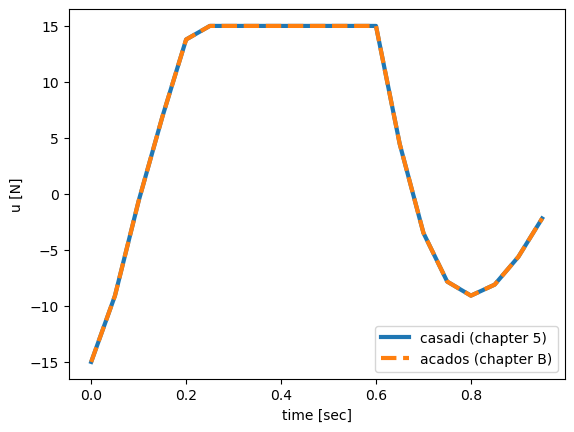

In [14]:
u_traj_acados = np.ndarray((K, nu))
for i in range(K):
    u_traj_acados[i,:] = ocp_solver.get(i, "u")

timestamp = np.array(range(K))*dt
plt.plot(timestamp, u_traj_casadi,linewidth=3,label="casadi (chapter 5)")
plt.plot(timestamp, u_traj_acados,"--", linewidth=3,label="acados (chapter B)")
plt.xlabel("time [sec]")
plt.ylabel("u [N]")
plt.legend()
plt.savefig("images/chapB_acados_casadi_cart_pole.png")
# plt.savefig("images/chapB_acados_casadi_cart_pole.pdf")